# Predicting the Geographical Origin of Music

## Overview

The quesion that we are looking at, is weather the geographical origin of songs can be predicted based on different audio features. The data can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/geographical+original+of+music). Prior exploration has been performed on this data. The most well-known study can be viewed [here](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7023456).

## Data Exploaration

The dataset consists of audio features that were extracted using [MARSYAS](http://marsyasweb.appspot.com/). The features that we are using can be seen as the key audio features of a song. We need to predict the geographical region of a song based on these features. The data does not include geographical regions, but rather lattitudanal and longitudinal coordinates. We would need to first perform clustering to figure out the geographical region for a set of coordinates.

## Data Preparation

In [101]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))

In [71]:
data = np.asarray(data)
data.shape

(1059, 70)

Each row is a song (observation) and each song is an audio feature. However, the last two columns are the geographical coordinates, so we need to split this appropriately.

In [72]:
X = data[:, 0:68]
y = data[:, 68:70]

print("X sample")
print(X[0, 1])
print("")
print("y sample")
print(y[0, 0:2])

X sample
7.835325

y sample
['-15.75' '-47.95']


Unfortunately, the coordinates are character values. We need to convert these to numerical values to see the relationship between them on a map.

In [73]:
y = y.astype(dtype = np.float)
print(y[0, 0:2])

[-15.75 -47.95]


Seeing that we need to predict the geographic area, we need to reduce the two coordinate prediction column to a single prediction column. Dimension reduction techniques such as PCA might work, but seeing that we know that there are 33 geographic locations within the data, clustering might be a better approach.

In [99]:
n_clusters = 33
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, algorithm='full')
kmeans = kmeans.fit(y)
labels = kmeans.predict(y)

#print('Centroids')
centroids = kmeans.cluster_centers_
#print(centroids)

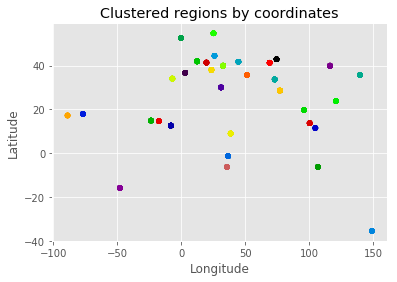

In [103]:
plt.style.use('ggplot')
label_color = [matplotlib.cm.spectral(float(l) /n_clusters) for l in labels]
plt.scatter(y[:, 1], y[:, 0], c = label_color, s=25)
plt.title("Clustered regions by coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.figure()

According to the research paper, data was collected from 33 countries/regions. As we can see from the plot above, it seems as if the coordinates provided are identical per region. However, it seeems as if some of the geographical regions are closer to each other than others. Even though countries or regions might be divided by borders, it seems logical that some of these geographical regions would be influenced by nearby located regions. This is important to bear in mind. If we are making inaccurate classifications, we might want to see whether the prediction is a nearby region. If this is the case, we should consider reducing the number of clusters.

In [104]:
y = labels

## Feature selection

We have 68 features, but we have no idea whether all the features are relevant or not. If we were building a regression model, we would've been able to use something like Lasso to determine which features can be eliminated. However, since we are trying to classify songs by region, we need to use a different approach.

We can use Python's `RFE` function to perform backward selection. We still need an estimator to perform feature selection. We can use RFE with a variety of estimators and see which performs the best in terms of minimising the number of features needed for the best accuracy score. We ideally want an estimator with an overall high accuracy score and preferably with a reduced amount of features to simplify the model. For this project we will use the `RFECV` function to combine cross validation with the `RFE` function.

Because it is a classification problem, we can consider the following estimators - random forest and SVM (SVC) with a linear kernel. K-nearestneighbours is another option, but because the model does not make use of coefficients, it is not appropriate for feature selection. For each estimator, we should iterate through a range of hyperparameters and consider each combination for feature selection - each model with optimal hyperparameters should be compared for feature selection.

Just to be save for when we finally predict our accuracy on our taining data, we should exclude this training data when selecting estimators, even if it while doing feature selection.

For svc optimal parameters are {'C': 1, 'gamma': 0.01, 'kernel': 'linear', 'random_state': 1234} with number of features : 59


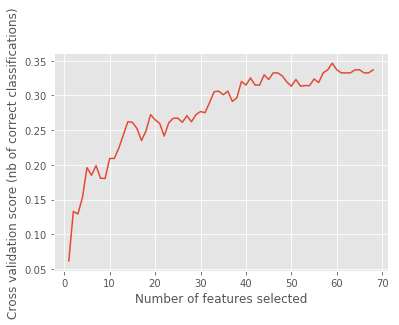

For rfc optimal parameters are {'n_estimators': 35} with number of features : 45


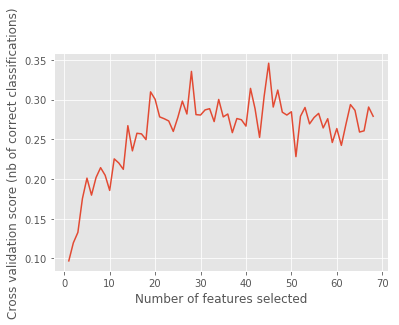

In [153]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import ParameterGrid




Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.8, random_state=1234)

estimators = {}

estimators['svc'] = SVC
estimators['rfc'] = RandomForestClassifier

params = {}
params['svc'] = {'kernel': ['linear'], 'C': [10**x for x in range(-2, 5, 1)], 
                 'gamma': [10**x for x in range(-2, 5, 1)], 
                'random_state': [1234]}
params['rfc'] = {'n_estimators': [5*x for x in range(1, 8, 1)]}

best_model = {}

for i, estimator in enumerate(estimators):
    model_params = ParameterGrid(params[estimator])
    grid = model_params
    
    best_model[estimator] = [0]
    
    for params_combo in grid:
        
        estimator_iter = estimators[estimator]
        estimator_iter = estimator_iter(**params_combo)
            
        rfecv = RFECV(estimator = estimator_iter, step=1, cv=StratifiedKFold(n_splits=2, shuffle=True),
                  scoring='accuracy')
        
        rfecv.fit(Xtrain, ytrain)
        
        if (max(rfecv.grid_scores_) > best_model[estimator][0]):
            best_model[estimator] = [max(rfecv.grid_scores_), params_combo, rfecv.n_features_, rfecv.grid_scores_]

    print("For %s optimal parameters are %s with number of features : %d" % (estimator, best_model[estimator][1], 
         best_model[estimator][2]))

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(best_model[estimator][3]) + 1), best_model[estimator][3])
    plt.show()

By looking at the graphs we can see that the accuracy scores are not as high as we would like a classification model to have. But the trends do indicate that we can neglect a few features that might be redundant. Even though we have an optimal number of features for each type of best model, this number of features shouldn't be taken too literal - as soon as the trend starts to level out (even if it does have a few random spikes after that), we should be aware that the additional features aren't helping the model much.

For both models it seems as if there is a lot of noise for models with more than 45 (out of 68) features. We can take the top ranked features from our best random forest model to use in our final model.

In [155]:
rfe = RandomForestClassifier(n_estimators=35)
rfecv = RFECV(estimator = rfe, step=1, cv=StratifiedKFold(n_splits=2, shuffle=True),
                  scoring='accuracy')
        
rfecv.fit(Xtrain, ytrain)

X_reduced = rfecv.transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced, y, test_size=0.8, random_state=1234)

In [157]:
X_reduced.shape

(1059, 50)

## Model Building

We can now use this these features to test out the same estimators and include k nearest neighbours.

In [165]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

estimators = {}

estimators['svc'] = SVC
estimators['rfc'] = RandomForestClassifier
estimators['knn'] = KNeighborsClassifier

params = {}
params['svc'] = {'kernel': ['linear'], 'C': [10**x for x in range(-2, 3, 1)], 
                 'gamma': [10**x for x in range(-2, 3, 1)], 
                'random_state': [1234]}
params['rfc'] = {'n_estimators': [5*x for x in range(1, 8, 1)]}

params['knn'] = {'n_neighbors': range(1, 15, 1), 'p': [1, 2]}

best_model = {}

for i, estimator in enumerate(estimators):
    model_params = ParameterGrid(params[estimator])
    grid = model_params
    
    best_model[estimator] = [0]
    
    for params_combo in grid:
        
        estimator_iter = estimators[estimator]
        estimator_iter = estimator_iter(**params_combo)
            
        estimator_iter.fit(Xtrain, ytrain)
        scores = cross_val_score(estimator_iter, Xtrain, ytrain, cv = 2, scoring='accuracy') # smallest class has 2 members
        
        if (scores.mean() > best_model[estimator][0]):
            best_model[estimator] = [scores.mean(), estimator_iter.get_params]

    print("For %s the best cv accuracy score is %s" % (estimator, best_model[estimator][0]))

For svc the best cv accuracy score is 0.255290287575
For rfc the best cv accuracy score is 0.242132392838
For knn the best cv accuracy score is 0.275908844276


## Re-clustering

The cross validation scorese for the differernt models are fairly similar, but all of them are really low. Due to this reason, it might be a good idea use clustering to re-assign the the classification groups. Seeing that the initial problem relates to geographic locations, we have to apply clustering based on the coordinates of the region. It would be fair to say that the US and Australia listens to similar types of music, but then we will be predicting music types instead of regions. For now, let's group by geographic locations.

We can apply each of the models above to different number of clusters to see if our accuracy improves.

In [186]:
with open('../data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))
    
data = np.asarray(data)
data.shape

y_coords = data[:, 68:70]
y_coords = y_coords.astype(dtype = np.float)

n_clusters = range(2, 33, 1)

accuracies = {'svc':[], 'rfc':[], 'knn':[]}

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, max_iter = 300, algorithm='full')
    kmeans = kmeans.fit(y_coords)
    labels = kmeans.predict(y_coords)
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, labels, test_size=0.8, random_state=1234)

    best_model = {}

    for i, estimator in enumerate(estimators):
        model_params = ParameterGrid(params[estimator])
        grid = model_params

        best_model[estimator] = [0]
        #accuracies[estimator] = []

        for params_combo in grid:

            estimator_iter = estimators[estimator]
            estimator_iter = estimator_iter(**params_combo)

            #estimator_iter.fit(Xtrain, ytrain)
            scores = cross_val_score(estimator_iter, Xtrain, ytrain, cv = 2, scoring='accuracy') # smallest class has 2 members

            if (scores.mean() > best_model[estimator][0]):
                best_model[estimator] = [scores.mean(), estimator_iter.get_params]

        accuracies[estimator].append(best_model[estimator][0])

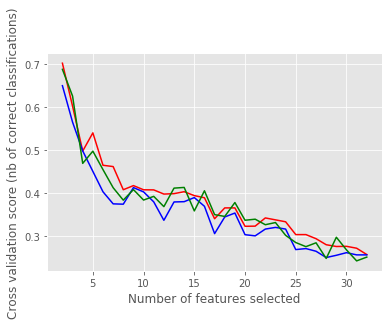

In [185]:
plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Mean cross validation score")
plt.plot(range(2, len(accuracies['knn']) + 2),accuracies['knn'], c = 'r')
plt.plot(range(2, len(accuracies['svc']) + 2),accuracies['svc'], c = 'b')
plt.plot(range(2, len(accuracies['rfc']) + 2),accuracies['rfc'], c = 'g')
plt.show()